# Programación Genética para Diseño de Circuitos Lógicos: Codificador de 7 Segmentos

## Objetivo
Este proyecto utiliza **Programación Genética (GP)** para encontrar automáticamente el diseño óptimo de un circuito lógico que controle un display de 7 segmentos (específicamente para el segmento 'a').

## Componentes Clave

### 1. Conjunto de Terminales y Funciones
- **Terminales (entradas):**
  - `A, B, C, D`: Bits de entrada (ej: 0000 para el dígito 0)
  - `0` y `1`: Constantes booleanas

- **Funciones (operadores lógicos):**
  - `AND(a, b)`: Operación Y lógica
  - `OR(a, b)`: Operación O lógica
  - `NOT(a)`: Operación NO lógica

### 2. Función de Aptitud
Evalúa qué tan bien una solución candidata (árbol lógico) clasifica correctamente las entradas según la tabla de verdad del segmento.

**Métrica:** Porcentaje de aciertos sobre los 10 casos de prueba (dígitos 0-9)

**Puntaje perfecto:** 1.0 (100% de aciertos)

### 3. Algoritmo Evolutivo
- Población: 100 individuos (árboles lógicos aleatorios)
- Selección: Torneo (tamaño 3)
- Operadores genéticos:
  - Cruzamiento (CX): Intercambio de subárboles
  - Mutación: Reemplazo aleatorio de subárboles
- Paro anticipado: Si se encuentra solución perfecta (fitness = 1.0)

## Datos de Entrenamiento
Tabla de verdad del segmento 'a' para dígitos 0-9:

| Dígito | A B C D | Salida |
|--------|---------|--------|
| 0      | 0 0 0 0 | 1      |
| 1      | 0 0 0 1 | 0      |
| 2      | 0 0 1 0 | 1      |
| ...    | ...     | ...    |
| 9      | 1 0 0 1 | 1      |

## Resultados Esperados
- **Mejor árbol encontrado:** Expresión lógica óptima (ej: `OR(AND(NOT(B), C), A)`)
- **Visualización:** Gráfico del árbol de decisión

## Bibliografía
- Librería DEAP: https://deap.readthedocs.io/

## Instrucciones de Uso
1. Ejecutar todas las celdas en orden
2. Los resultados aparecerán al final del notebook
3. Para otros segmentos, modificar los datos de entrenamiento

**Nota:** El algoritmo puede tomar varios segundos en completarse dependiendo de la complejidad del problema.

In [2]:
# Paso 1: Instalar librería
!pip install deap

# Paso 2: Importaciones
import operator
import random
from deap import base, creator, tools, gp
import numpy as np

# Paso 3: Funciones lógicas
def AND(a, b): return a and b
def OR(a, b): return a or b
def NOT(a): return not a

# Paso 4: Definición del conjunto de primitivas
pset = gp.PrimitiveSet("MAIN", 4)
pset.renameArguments(ARG0='A', ARG1='B', ARG2='C', ARG3='D')
pset.addPrimitive(AND, 2)
pset.addPrimitive(OR, 2)
pset.addPrimitive(NOT, 1)
pset.addTerminal(0)
pset.addTerminal(1)

# Paso 5: Creación de tipos de individuos
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

# Paso 6: Toolbox general
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

# Paso 7: Función para entrenar cualquier segmento con paro anticipado
def entrenar_segmento(nombre_segmento, training_data, max_generaciones=30):
    def eval_segment(individual):
        func = toolbox.compile(expr=individual)
        score = 0
        for (inputs, expected) in training_data:
            try:
                if func(*inputs) == expected:
                    score += 1
            except:
                pass
        return score / len(training_data),

    toolbox.register("evaluate", eval_segment)

    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # Entrenamiento con paro anticipado
    for gen in range(max_generaciones):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring
        hof.update(pop)

        record = stats.compile(pop)
        if gen == 0:
          print(f"{'Gen':>4} | {'Avg Fitness':>12} | {'Max Fitness':>12}")
          print("-" * 37)
        print(f"{gen:>4} | {record['avg']:.6f}     | {record['max']:.6f}")

        # 💡 Paro anticipado si fitness perfecto
        if hof[0].fitness.values[0] >= 1.0:
            print(f"\n✅ Solución perfecta encontrada en generación {gen}")
            break

    return hof[0]

# Paso 8: Datos para segmento 'a'
training_data_a = [
    ((0, 0, 0, 0), 1),
    ((0, 0, 0, 1), 0),
    ((0, 0, 1, 0), 1),
    ((0, 0, 1, 1), 1),
    ((0, 1, 0, 0), 0),
    ((0, 1, 0, 1), 1),
    ((0, 1, 1, 0), 1),
    ((0, 1, 1, 1), 1),
    ((1, 0, 0, 0), 1),
    ((1, 0, 0, 1), 1)
]


# Paso 9: Ejecutar entrenamiento para ambos segmentos
mejor_a = entrenar_segmento("a", training_data_a)
print("MEJOR ARRBOL LOGICO PARA A:")
print(mejor_a)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.4 MB/s eta 0:00:00
 Gen |  Avg Fitness |  Max Fitness
-------------------------------------
   0 | 0.471000     | 0.800000
   1 | 0.640000     | 0.800000
   2 | 0.714000     | 0.800000
   3 | 0.745000     | 0.800000
   4 | 0.752000     | 0.800000
   5 | 0.749000     | 0.800000
   6 | 0.769000     | 0.900000
   7 | 0.754000     | 0.900000
   8 | 0.771000     | 0.900000
   9 | 0.747000     | 0.900000
  10 | 0.788000     | 0.900000
  11 | 0.788000     | 0.900000
  12 | 0.805000     | 0.900000
  13 | 0.814000     | 0.900000
  14 | 0.806000     | 0.900000
  15 | 0.837000     | 0.900000
  16 | 0.854000     | 0.900000
  17 | 0.848000     | 0.900000
  18 | 0.851000     | 0.900000
  19 | 0.852000     | 0.900000
  20 | 0.862000     | 1.000000

✅ Solución perfecta encontrada en generación 20
MEJOR ARRBOL LOGICO PARA A:
OR(A, OR(AND(OR(OR(C, NOT(OR(D, OR(AND(OR(1, AND(OR(AND(B, B), 1), AND(D, AND(AND(OR(C, C), 0), C)))), 0), AND(OR(0, B)

**A continuación podrá ver de forma gráfica el arbol lógico.**

# Módulo de Visualización de Árboles Lógicos para Programación Genética

## Objetivo
Este módulo permite visualizar árboles de expresiones lógicas generados por algoritmos de Programación Genética como imágenes gráficas en formato PNG.

## Funciones principales

### `parse_expression(expr_str)`
**Propósito:**  
Convierte una expresión lógica en formato de cadena a una estructura de árbol anidada.

**Características:**
- Elimina espacios innecesarios
- Usa expresiones regulares para tokenizar la entrada
- Construye recursivamente una estructura de tuplas que representa el árbol

**Ejemplo:**
```python
Entrada: "OR(AND(A,B),NOT(C))"
Salida: ('OR', ('AND', 'A', 'B'), ('NOT', 'C'))

### `draw_logic_tree(variable, nombre)`

**Propósito:**

Genera y muestra una representación gráfica del árbol lógico.

**Proceso:**

- Convierte la expresión a estructura de árbol
- Crea un gráfico usando Graphviz
- Añade nodos y conexiones de forma recursiva
- Guarda la imagen como archivo PNG
- Muestra la imagen directamente en el notebook

('OR', 'A', ('OR', ('AND', ('OR', ('OR', 'C', ('NOT', ('OR', 'D', ('OR', ('AND', ('OR', 1, ('AND', ('OR', ('AND', 'B', 'B'), 1), ('AND', 'D', ('AND', ('AND', ('OR', 'C', 'C'), 0), 'C')))), 0), ('AND', ('OR', 0, 'B'), ('NOT', 0)))))), ('AND', ('OR', 'B', 'C'), 'D')), 1), 0))


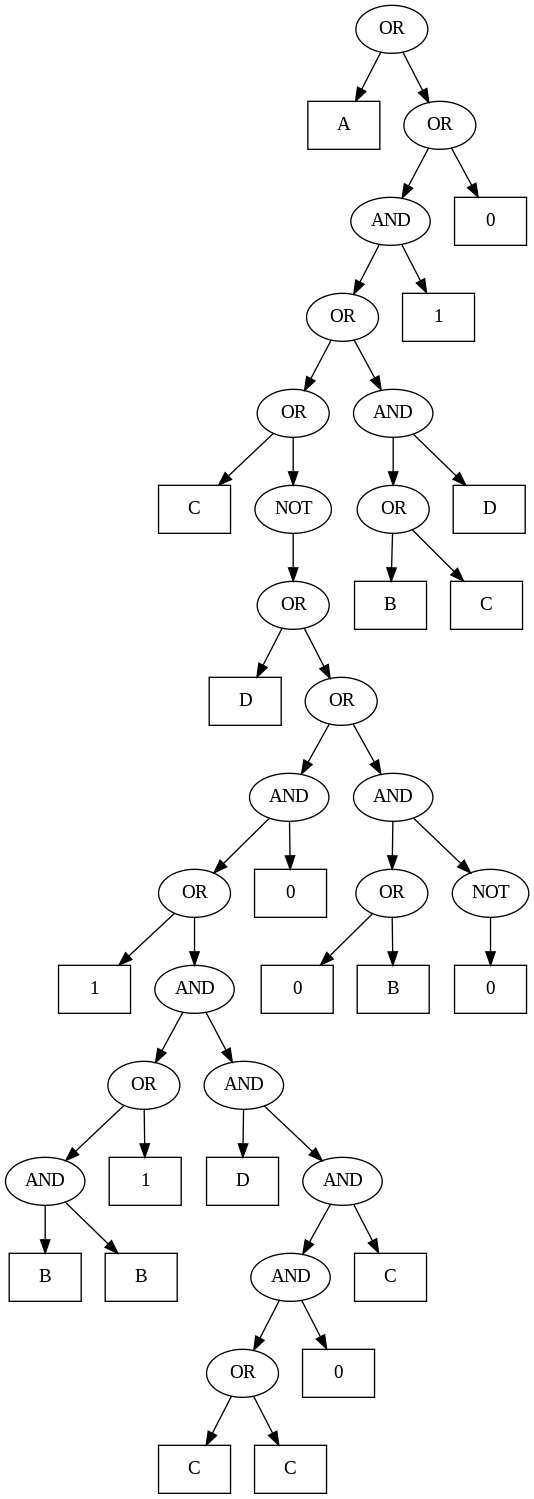

In [3]:
import re

#####-------FUNCION ENCARGA DE PARSEAR EL ÁRBOL LÓGICO
def parse_expression(expr_str):
    # Limpieza inicial de espacios
    expr_str = expr_str.replace(" ", "")

    # Tokenización usando expresiones regulares
    tokens = re.findall(r'\w+|\(|\)|,', expr_str)

    def parse_tokens(tokens):
        if not tokens:
            return None

        token = tokens.pop(0)

        if token in ("AND", "OR", "NOT"):
            assert tokens.pop(0) == "(", "Expected '(' after operator"
            args = []
            while tokens[0] != ")":
                args.append(parse_tokens(tokens))
                if tokens[0] == ",":
                    tokens.pop(0)  # remove comma
            tokens.pop(0)  # remove ')'
            return tuple([token] + args)

        elif token.isdigit():
            return int(token)

        else:
            return token  # variable: A, B, C...

    return parse_tokens(tokens)

##############------ENCARGADA DE GENERAR LA IMAGEN------######

import graphviz
from IPython.display import Image, display

# Definimos la expresión lógica como árbol con estructuras anidadas
def build_tree(variable):
    expr_str = str(variable)
    return parse_expression(expr_str)

# Función recursiva para agregar nodos al grafo
def add_nodes_edges(expr, graph, parent=None, count=[0]):
    if isinstance(expr, tuple):
        node_label = expr[0]
        node_name = f"node{count[0]}"
        graph.node(node_name, node_label)
        if parent:
            graph.edge(parent, node_name)
        count[0] += 1
        for subexpr in expr[1:]:
            add_nodes_edges(subexpr, graph, node_name, count)
    else:
        leaf_name = f"leaf{count[0]}"
        graph.node(leaf_name, str(expr), shape="box")
        if parent:
            graph.edge(parent, leaf_name)
        count[0] += 1

# Función principal
def draw_logic_tree(variable,nombre):
    expr = build_tree(variable)
    print(str(expr))
    dot = graphviz.Digraph(format="png")
    add_nodes_edges(expr, dot)
    dot.render(f"{nombre}", view=True)

# Ejecutar
if __name__ == "__main__":
    draw_logic_tree(mejor_a,"logic_tree_for_a")

display(Image(filename='logic_tree_for_a.png'))  # Muestra la imagen en la celda

SEGUIMOS REPITIENDO LA MISMA LÓGICA PARA LAS DEMÁS SÁLIDAS B, C, D, E, F, G.

In [4]:
# Datos para segmento 'b'
training_data_b = [
    ((0, 0, 0, 0), 1),
    ((0, 0, 0, 1), 1),
    ((0, 0, 1, 0), 1),
    ((0, 0, 1, 1), 1),
    ((0, 1, 0, 0), 1),
    ((0, 1, 0, 1), 0),
    ((0, 1, 1, 0), 0),
    ((0, 1, 1, 1), 1),
    ((1, 0, 0, 0), 1),
    ((1, 0, 0, 1), 1)
]

mejor_b = entrenar_segmento("b", training_data_b)
print(mejor_b)

 Gen |  Avg Fitness |  Max Fitness
-------------------------------------
   0 | 0.461000     | 0.800000
   1 | 0.604000     | 0.800000
   2 | 0.696000     | 0.800000
   3 | 0.747000     | 0.800000
   4 | 0.736000     | 0.800000
   5 | 0.723000     | 0.800000
   6 | 0.733000     | 0.800000
   7 | 0.751000     | 0.800000
   8 | 0.726000     | 0.900000
   9 | 0.744000     | 0.900000
  10 | 0.754000     | 0.900000
  11 | 0.773000     | 0.900000
  12 | 0.774000     | 0.900000
  13 | 0.787000     | 0.900000
  14 | 0.816000     | 0.900000
  15 | 0.817000     | 0.900000
  16 | 0.854000     | 0.900000
  17 | 0.842000     | 1.000000

✅ Solución perfecta encontrada en generación 17
OR(NOT(AND(B, NOT(NOT(OR(D, AND(B, C)))))), AND(C, D))


('OR', ('NOT', ('AND', 'B', ('NOT', ('NOT', ('OR', 'D', ('AND', 'B', 'C')))))), ('AND', 'C', 'D'))
OR(NOT(AND(B, NOT(NOT(OR(D, AND(B, C)))))), AND(C, D))


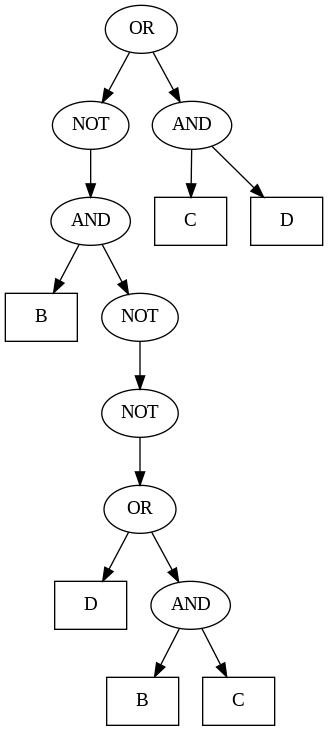

In [5]:
# Ejecutar
if __name__ == "__main__":
    draw_logic_tree(mejor_b,"logic_tree_for_b")

print(mejor_b)
display(Image(filename='logic_tree_for_b.png'))  # Muestra la imagen en la celda

**PARA C**

 Gen |  Avg Fitness |  Max Fitness
-------------------------------------
   0 | 0.480000     | 0.900000
   1 | 0.678000     | 0.900000
   2 | 0.742000     | 0.900000
   3 | 0.760000     | 1.000000

✅ Solución perfecta encontrada en generación 3
OR(OR(B, D), NOT(C))
('OR', ('OR', 'B', 'D'), ('NOT', 'C'))


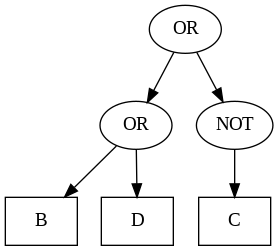

In [6]:
# Datos para segmento 'c'
training_data_c = [
    ((0, 0, 0, 0), 1),
    ((0, 0, 0, 1), 1),
    ((0, 0, 1, 0), 0),
    ((0, 0, 1, 1), 1),
    ((0, 1, 0, 0), 1),
    ((0, 1, 0, 1), 1),
    ((0, 1, 1, 0), 1),
    ((0, 1, 1, 1), 1),
    ((1, 0, 0, 0), 1),
    ((1, 0, 0, 1), 1)
]

mejor_c = entrenar_segmento("c", training_data_c)
print(mejor_c)
#-AQUÍ PROCEDEMOS A HACER LA IMPRESIÓN DE UNA VEZ
# Ejecutar
if __name__ == "__main__":
    draw_logic_tree(mejor_c,"logic_tree_for_c")

display(Image(filename='logic_tree_for_c.png'))  # Muestra la imagen en la celda

**PARA D**

 Gen |  Avg Fitness |  Max Fitness
-------------------------------------
   0 | 0.496000     | 0.700000
   1 | 0.558000     | 0.700000
   2 | 0.579000     | 0.800000
   3 | 0.593000     | 0.800000
   4 | 0.610000     | 0.700000
   5 | 0.636000     | 0.700000
   6 | 0.678000     | 0.700000
   7 | 0.652000     | 0.700000
   8 | 0.662000     | 0.700000
   9 | 0.659000     | 0.700000
  10 | 0.665000     | 0.700000
  11 | 0.651000     | 0.700000
  12 | 0.656000     | 0.800000
  13 | 0.666000     | 0.800000
  14 | 0.653000     | 0.800000
  15 | 0.653000     | 0.800000
  16 | 0.671000     | 0.800000
  17 | 0.654000     | 0.800000
  18 | 0.687000     | 0.800000
  19 | 0.680000     | 0.800000
  20 | 0.686000     | 0.800000
  21 | 0.718000     | 0.800000
  22 | 0.707000     | 0.800000
  23 | 0.725000     | 0.800000
  24 | 0.736000     | 0.800000
  25 | 0.762000     | 0.800000
  26 | 0.728000     | 0.900000
  27 | 0.731000     | 0.900000
  28 | 0.752000     | 0.900000
  29 | 0.765000     | 0.9000

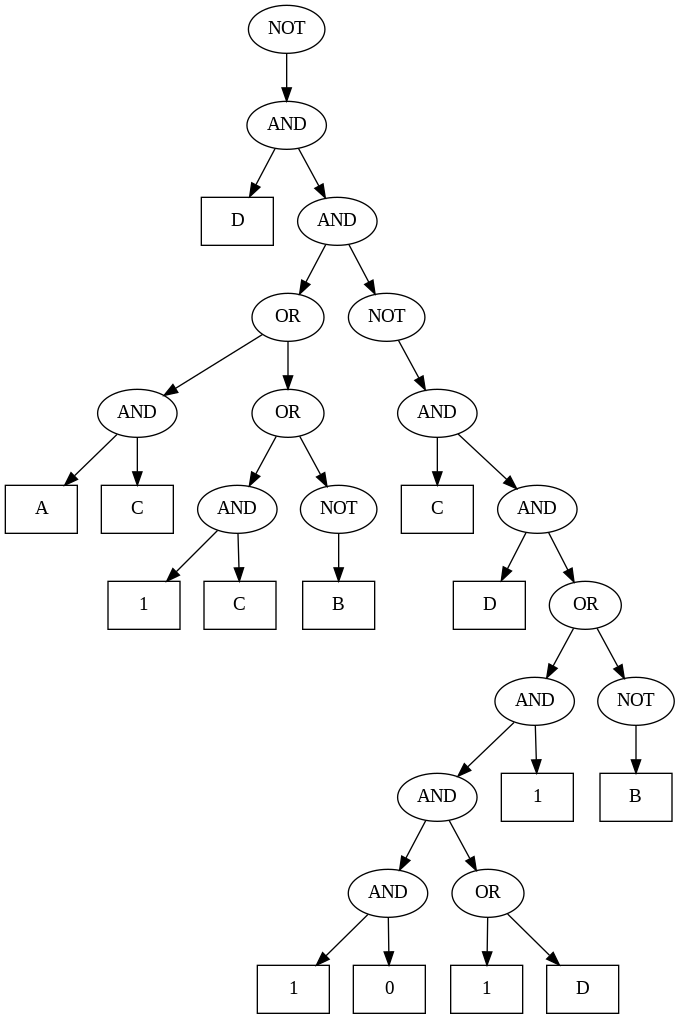

In [7]:
# Datos para segmento 'D'
training_data_d = [
    ((0, 0, 0, 0), 1), #0
    ((0, 0, 0, 1), 0), #1
    ((0, 0, 1, 0), 1), #2
    ((0, 0, 1, 1), 1), #3
    ((0, 1, 0, 0), 0), #4
    ((0, 1, 0, 1), 1), #5
    ((0, 1, 1, 0), 1), #6
    ((0, 1, 1, 1), 0), #7
    ((1, 0, 0, 0), 1), #8
    ((1, 0, 0, 1), 0)  #9
]

mejor_d = entrenar_segmento("d", training_data_d)
print(mejor_d)
#-AQUÍ PROCEDEMOS A HACER LA IMPRESIÓN DE UNA VEZ
# Ejecutar
if __name__ == "__main__":
    draw_logic_tree(mejor_d,"logic_tree_for_d")

display(Image(filename='logic_tree_for_d.png'))  # Muestra la imagen en la celda

PARA E

 Gen |  Avg Fitness |  Max Fitness
-------------------------------------
   0 | 0.458000     | 0.900000
   1 | 0.518000     | 0.900000
   2 | 0.600000     | 0.900000
   3 | 0.604000     | 0.900000
   4 | 0.676000     | 0.900000
   5 | 0.740000     | 0.900000
   6 | 0.762000     | 0.900000
   7 | 0.727000     | 0.900000
   8 | 0.769000     | 0.900000
   9 | 0.809000     | 0.900000
  10 | 0.763000     | 0.900000
  11 | 0.787000     | 0.900000
  12 | 0.833000     | 0.900000
  13 | 0.811000     | 0.900000
  14 | 0.800000     | 0.900000
  15 | 0.811000     | 0.900000
  16 | 0.809000     | 0.900000
  17 | 0.810000     | 0.900000
  18 | 0.835000     | 0.900000
  19 | 0.820000     | 0.900000
  20 | 0.808000     | 0.900000
  21 | 0.791000     | 0.900000
  22 | 0.844000     | 0.900000
  23 | 0.823000     | 0.900000
  24 | 0.840000     | 0.900000
  25 | 0.838000     | 0.900000
  26 | 0.845000     | 0.900000
  27 | 0.847000     | 0.900000
  28 | 0.843000     | 0.900000
  29 | 0.834000     | 0.9000

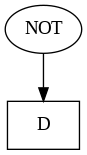

In [8]:
# Datos para segmento 'e'
training_data_e = [
    ((0, 0, 0, 0), 1), #0
    ((0, 0, 0, 1), 0), #1
    ((0, 0, 1, 0), 1), #2
    ((0, 0, 1, 1), 0), #3
    ((0, 1, 0, 0), 0), #4
    ((0, 1, 0, 1), 0), #5
    ((0, 1, 1, 0), 1), #6
    ((0, 1, 1, 1), 0), #7
    ((1, 0, 0, 0), 1), #8
    ((1, 0, 0, 1), 0)  #9
]

mejor_e = entrenar_segmento("e", training_data_e)
print(mejor_e)
#-AQUÍ PROCEDEMOS A HACER LA IMPRESIÓN DE UNA VEZ
# Ejecutar
if __name__ == "__main__":
    draw_logic_tree(mejor_e,"logic_tree_for_e")

display(Image(filename='logic_tree_for_e.png'))  # Muestra la imagen en la celda

**PARA F**

 Gen |  Avg Fitness |  Max Fitness
-------------------------------------
   0 | 0.511000     | 0.800000
   1 | 0.589000     | 0.800000
   2 | 0.608000     | 0.800000
   3 | 0.598000     | 0.800000
   4 | 0.630000     | 0.800000
   5 | 0.664000     | 0.800000
   6 | 0.694000     | 0.800000
   7 | 0.698000     | 0.800000
   8 | 0.734000     | 0.800000
   9 | 0.730000     | 0.800000
  10 | 0.695000     | 0.900000
  11 | 0.716000     | 0.900000
  12 | 0.764000     | 0.900000
  13 | 0.759000     | 0.900000
  14 | 0.758000     | 0.900000
  15 | 0.797000     | 0.900000
  16 | 0.822000     | 0.900000
  17 | 0.840000     | 0.900000
  18 | 0.856000     | 1.000000

✅ Solución perfecta encontrada en generación 18
OR(A, OR(AND(B, NOT(C)), AND(OR(NOT(C), AND(B, OR(NOT(OR(0, D)), OR(A, B)))), OR(AND(A, B), NOT(D)))))
('OR', 'A', ('OR', ('AND', 'B', ('NOT', 'C')), ('AND', ('OR', ('NOT', 'C'), ('AND', 'B', ('OR', ('NOT', ('OR', 0, 'D')), ('OR', 'A', 'B')))), ('OR', ('AND', 'A', 'B'), ('NOT', 'D')))))


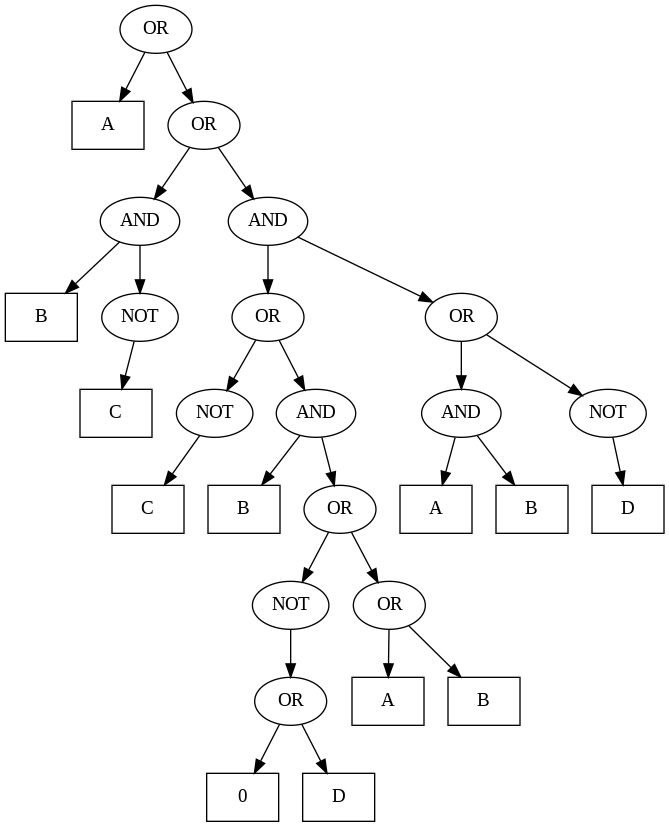

In [9]:
# Datos para segmento 'f'
training_data_f = [
    ((0, 0, 0, 0), 1), #0
    ((0, 0, 0, 1), 0), #1
    ((0, 0, 1, 0), 0), #2
    ((0, 0, 1, 1), 0), #3
    ((0, 1, 0, 0), 1), #4
    ((0, 1, 0, 1), 1), #5
    ((0, 1, 1, 0), 1), #6
    ((0, 1, 1, 1), 0), #7
    ((1, 0, 0, 0), 1), #8
    ((1, 0, 0, 1), 1)  #9
]

mejor_f = entrenar_segmento("f", training_data_f)
print(mejor_f)
#-AQUÍ PROCEDEMOS A HACER LA IMPRESIÓN DE UNA VEZ
# Ejecutar
if __name__ == "__main__":
    draw_logic_tree(mejor_f,"logic_tree_for_f")

display(Image(filename='logic_tree_for_f.png'))  # Muestra la imagen en la celda

**PARA G**

 Gen |  Avg Fitness |  Max Fitness
-------------------------------------
   0 | 0.456000     | 0.700000
   1 | 0.550000     | 0.800000
   2 | 0.626000     | 0.800000
   3 | 0.677000     | 0.800000
   4 | 0.699000     | 0.900000
   5 | 0.677000     | 0.800000
   6 | 0.702000     | 0.800000
   7 | 0.692000     | 0.800000
   8 | 0.738000     | 0.800000
   9 | 0.757000     | 0.800000
  10 | 0.755000     | 0.900000
  11 | 0.766000     | 0.900000
  12 | 0.770000     | 0.900000
  13 | 0.773000     | 0.900000
  14 | 0.761000     | 0.900000
  15 | 0.788000     | 0.900000
  16 | 0.789000     | 0.900000
  17 | 0.811000     | 0.900000
  18 | 0.821000     | 0.900000
  19 | 0.824000     | 0.900000
  20 | 0.839000     | 0.900000
  21 | 0.859000     | 0.900000
  22 | 0.855000     | 0.900000
  23 | 0.862000     | 0.900000
  24 | 0.861000     | 0.900000
  25 | 0.875000     | 0.900000
  26 | 0.882000     | 0.900000
  27 | 0.869000     | 0.900000
  28 | 0.876000     | 0.900000
  29 | 0.878000     | 0.9000

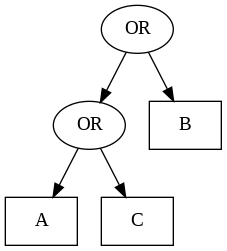

In [10]:
# Datos para segmento 'g'
training_data_g = [
    ((0, 0, 0, 0), 0), #0
    ((0, 0, 0, 1), 0), #1
    ((0, 0, 1, 0), 1), #2
    ((0, 0, 1, 1), 1), #3
    ((0, 1, 0, 0), 1), #4
    ((0, 1, 0, 1), 1), #5
    ((0, 1, 1, 0), 1), #6
    ((0, 1, 1, 1), 0), #7
    ((1, 0, 0, 0), 1), #8
    ((1, 0, 0, 1), 1)  #9
]

mejor_g = entrenar_segmento("g", training_data_g)
print(mejor_g)
#-AQUÍ PROCEDEMOS A HACER LA IMPRESIÓN DE UNA VEZ
# Ejecutar
if __name__ == "__main__":
    draw_logic_tree(mejor_g,"logic_tree_for_g")

display(Image(filename='logic_tree_for_g.png'))  # Muestra la imagen en la celda